# Imports

In [1]:
import numpy as np
import pandas as pd
import sys
import glob
import matplotlib.pyplot as plt
import math
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Dataset

In [2]:
homus_paths = []
for subfolder in glob.glob("/content/drive/MyDrive/TCC/HOMUS/HOMUS_V2/*"):
  files = glob.glob(subfolder + "/*")
  for file in files:
    homus_paths.append(file)
homus_data = np.load("homus_data.npy", allow_pickle=True)
homus_labels = np.load("homus_labels.npy", allow_pickle=True)
homus_strokes_labels = np.load("homus_strokes_labels.npy", allow_pickle=True)

xtrain, xtest, ytrain, ytest = train_test_split(homus_data, homus_strokes_labels, random_state=42)


In [ ]:
print(len(homus_data))
print(len(homus_strokes_labels))
print(len(xtrain))
print(len(xtest))

15200
15200
11400
3800


In [ ]:
print(f"homus: {len(homus_data)}")
print(homus_data[0])
print(f"\nhomus strokes labels: {len(homus_strokes_labels)}")
print(homus_strokes_labels[1:3])
# print(f"\nsnu {len(snu_data)}")
# print(snu_data[0])
# print(f"\ncapitain {len(capitain_data)}")
# print(capitain_data[0])

homus: 15200
[array([[ 13, 120],
       [ 13, 120],
       [ 14, 122],
       [ 15, 126],
       [ 16, 132],
       [ 16, 137],
       [ 18, 140],
       [ 19, 140],
       [ 21, 140],
       [ 21, 140]])
 array([[ 29, 124],
       [ 31, 124],
       [ 35, 126],
       [ 36, 127],
       [ 35, 130],
       [ 34, 134],
       [ 34, 137],
       [ 36, 139],
       [ 41, 140],
       [ 41, 139],
       [ 41, 139]])
 array([[ 28, 170],
       [ 30, 171],
       [ 36, 179],
       [ 39, 184],
       [ 39, 189],
       [ 39, 191],
       [ 35, 191],
       [ 32, 188],
       [ 30, 184],
       [ 30, 179],
       [ 35, 170],
       [ 38, 165],
       [ 37, 162],
       [ 33, 163],
       [ 26, 166],
       [ 19, 171],
       [ 18, 174],
       [ 18, 174]])]

homus strokes labels: 15200
[array(['2-4-Time', '100', '100'], dtype='<U8')
 array(['Quarter-Note', '0', '1'], dtype='<U12')]


# Strokes classification

In [3]:
class STROKE():
  def __init__(self, d=4, staff_height=14):
    """
    Parameters
    ----------

    """
    # Initialize descriptive features of STROKECLF
    self.d = d
    self.staff_height = staff_height
    self.x = None
    self.y = None
    self.erros = None
    self.centers = []
    self.si = None
    self.hda = None
    self.hua = None


  def __FFC(self, p1=None, p2=None, directed=True):  
    x1, y1 = p1[0], p1[1]
    x2, y2 = p2[0], p2[1]
    # auxiliar 
    if directed:
      ffc1aux = {0.0 : 0, 90.0 : 2, 180.0 : 4, 270.0: 6}
      ffc2aux = [1,3,5,7]

    else:
      ffc1aux = {0.0 : 0, 90.0 : 2, 180.0 : 0, 270.0: 2}
      ffc2aux = [1,3,1,3]

    rad = math.atan2(y2-y1, x2-x1)
    angle  = 360.0 + math.degrees(rad) if (rad < 0) else math.degrees(rad)

    if angle in [0.0, 90.0, 180.0, 270]:
      return ffc1aux[angle]
    else:
      quadrant = int(angle/90)
      return ffc2aux[quadrant]      


  def SI(self, stroke):
    minusquared = np.array([((p2 - p1)**2) for p1, p2 in zip(stroke, stroke[1:])])
    ds = np.sum(minusquared ** 2, axis=1) ** .5
    l = np.sum(ds)  # sum of the Euclidean distances of each sequence of points

    xmax, ymax = np.amax(stroke, axis=0)
    xmin, ymin = np.amin(stroke, axis=0)
    w = xmax-xmin
    h = ymax-ymin
    # center:
    xc = xmin + w/2
    yc = ymin + h/2
    self.centers.append(np.array([xc, yc]))
    return w, h, l

  def HDA(self, stroke, directed=True):
    ffc = np.array([self.__FFC(p1, p2, directed) for p1, p2 in zip(stroke, stroke[1:])])
    return np.histogram(ffc, bins=list(range(9)))[0] if directed else np.histogram(ffc, bins=list(range(5)))[0]
    
  def HUA(self, stroke):
    return self.HDA(stroke, directed=False)

  def getStrokeFeatures(self, symbol):
    self.si = np.array(list(map(strokes.SI, symbol))) / self.staff_height
    self.hda = np.array(list(map(strokes.HDA, symbol)))
    self.hua = np.array(list(map(strokes.HUA, symbol)))
    return np.concatenate((self.si.T, self.hda.T, self.hua.T)).T

  def fitall(self, data, stroke_labels):
    x, y, erros = [], [] ,[]
    i = 0
    for symbol, labels in zip(data, stroke_labels):
      if(len(symbol) != len(labels[1:])):
        erros.append(i)
      strokefeat = self.getStrokeFeatures(symbol)
      x.extend(strokefeat)
      y.extend(labels[1:(len(strokefeat)+1)])
      i = i + 1
    self.x = np.array(x)
    self.y = np.array(y)
    self.erros = erros

  def fit(self, symbol, labels):
    x, y = [], []
    strokefeat = self.getStrokeFeatures(symbol)
    self.x = np.array(strokefeat)
    self.y = np.array(labels[1:(len(strokefeat)+1)])


      

In [4]:
%%time
strokes = STROKE()
strokes.fitall(xtrain, ytrain)

CPU times: user 11.8 s, sys: 40.1 ms, total: 11.9 s
Wall time: 11.9 s


In [ ]:
def getIdSymbol(file):
  lp = file.split("/")
  return lp[-2] + '/' + lp[-1]

e = np.array(homus_paths)[strokes.erros]
e = np.array([getIdSymbol(f) for f in e])
print("erro nos arquivos:")
print(e)

erro nos arquivos:
['1/1-50.txt' '10/10-83.txt' '16/16-128.txt' '24/24-16.txt'
 '29/29-106.txt' '30/30-36.txt' '40/40-13.txt' '53/53-89.txt'
 '54/54-67.txt' '57/57-100.txt' '60/60-123.txt' '76/76-130.txt']


### randomizedSeacrh

In [ ]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
clf_strokes = RandomizedSearchCV(SVC(), parameters, random_state=0)
clf_strokes.fit(strokes.x, strokes.y)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=None,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': [1, 10],
                                        'kernel': ('linear', 'rbf')},
                   pre_dispatch='2*n_jobs', random_state=0, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [ ]:
clf_strokes.best_params_

{'C': 10, 'kernel': 'linear'}

### svm classification

In [5]:
stroke = np.array([[2, 3], [3, 4], [5, 5], [3, 3]])
minusquared = np.array([((p2 - p1)**2) for p1, p2 in zip(stroke, stroke[1:])])
minusquared

array([[1, 1],
       [4, 1],
       [4, 4]])

In [10]:
%%time
svc_strokes = SVC(C=10, kernel='linear')
svc_strokes.fit(strokes.x, strokes.y)

CPU times: user 27min 46s, sys: 1.39 s, total: 27min 47s
Wall time: 27min 41s


In [12]:
%%time
strokes_test = STROKE(d=4)
strokes_test.fitall(xtest, ytest)

CPU times: user 3.86 s, sys: 16 ms, total: 3.88 s
Wall time: 3.9 s


In [13]:
%%time
strokes_predicted = svc_strokes.predict(strokes_test.x)

CPU times: user 8.14 s, sys: 10 ms, total: 8.15 s
Wall time: 8.12 s


In [14]:
print("Score: ", svc_strokes.score(strokes_test.x, strokes_test.y))

Score:  0.7353151496577791


In [15]:
strokes_names = ['None', 'Vline', 'Hline', 'CommonTimeArc', 'Dot', 'WHead', 'BHead', 'LSlash', 'RSlash', 'StUHook', 'StLHook', '8Rest', 'RestArc', 'RestArc2', 
                 'QRest', 'Fill', 'WRest', 'GClef', 'FClefArc', 'CClef2Arc', 'RevNaturalRT', 'NaturalRt', 'Lightning', 'Flat', 'timeSignatures']
len(strokes_names)

25

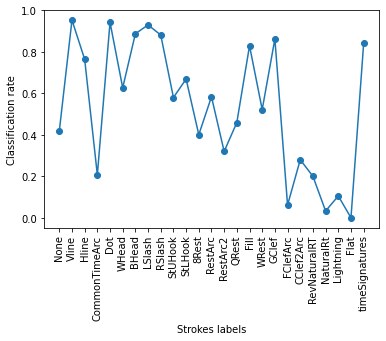

In [21]:
precisionPerClass = confusion_matrix(np.array(strokes_test.y, dtype='int'), np.array(strokes_predicted, dtype='int'), normalize="true").diagonal()
plt.plot(strokes_names, precisionPerClass, "-o")
plt.xticks(rotation=90)
plt.xlabel("Strokes labels")
plt.ylabel("Classification rate")
plt.savefig('strokes_recog.eps', format='eps')
plt.show()

# Symbol Classification

In [ ]:
class SYMBOL():
  def __init__(self, d=4, staff_height=14):
    """
    Parameters
    ----------
    """
    # Initialize descriptive features of STROKECLF
    self.x = None
    self.y = None
    self.strokes = STROKE(d, staff_height)

  def get_q(self, stroke, center, staff_height):
    return [center[0], center[1], stroke[0]*staff_height, stroke[1]*staff_height]

  def fit(self, symbols, labels, clf_stroke):
    symbolsvec = []
    y = []
    for s, labels in zip(symbols, labels):
      svec = []
      self.strokes.fit(s, labels)
      print(self.strokes.centers)
      print()
      for stroke, center in zip(self.strokes.x, self.strokes.centers):
        pred = int(clf_stroke.predict(stroke))
        q = get_q(stroke, center, strokes.staff_height)
        svec.extend([pred] + q)
      symbolsvec.append(np.array(svec))
      y.append(labels[0])
    self.x = symbolsvec
    self.y = y
    return self


In [ ]:
len(ytrain)

11400

In [ ]:
symbols = SYMBOL()
symbols.fit(xtrain, ytrain, svc_strokes)

#svc_symbols = SVC(C=10, kernel='linear')
#svc_symbols.fit(symbols.x, symbols.y)
#symbols.x

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]



KeyboardInterrupt: ignored